# Building a Regression Model in PyTorch

[MachineLearningMastery](https://machinelearningmastery.com/building-a-regression-model-in-pytorch/?utm_source=drip&utm_medium=email&utm_campaign=Use+PyTorch+deep+learning+models+with+scikit-learn&utm_content=Use+PyTorch+deep+learning+models+with+scikit-learn)

After completing this post, you will know:

* How to load data from scikit-learn and adapt it for PyTorch models
* How to create a neural network for regerssion problem using PyTorch
* How to improve model performance with data preparation techniques

## Dataset

The dataset you will use in this tutorial is the [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

This is a dataset that describes the median house value for California districts. Each data sample is a census block group. The target variable is the median house value in USD 100,000 in 1990 and there are 8 input features, each describing something about the house. They are, namely,

    MedInc: median income in block group
    HouseAge: median house age in block group
    AveRooms: average number of rooms per household
    AveBedrms: average number of bedrooms per household
    Population: block group population
    AveOccup: average number of household members
    Latitude: block group centroid latitude
    Longitude: block group centroid longitude
    
This data is special because the input data is in vastly different scale. For example, the number of rooms per house is usually small but the population per block group is usually large. Moreover, most features should be positive but the longitude must be negative (because that’s about California). Handling such diversity of data is a challenge to some machine learning models.

You can get the dataset from scikit-learn, which in turn, is downloaded from the Internet at realtime:

In [1]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
print(data.feature_names)

X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


## Building a Model and Train

This is a regression problem. Unlike classification problems, the output variable is a continuous value. In case of neural networks, you usually use linear activation at the output layer (i.e., no activation) such that the output range theoretically can be anything from negative infinty to positive infinity.

Also for regression problems, you should never expect the model to predict the values perfectly. Therefore, you should care about how close the prediction is to the actual value. The loss metric that you can use for this is the mean square error (MSE) or mean absolute error (MAE). But you may also interested in the root mean squared error (RMSE) because that’s a metric in the same unit as your output variable.

Let’s try the traditional design of a neural network, namely, the pyramid structure. A pyramid structure is to have the number of neurons in each layer decreasing as the network progresses to the output. The number of input features is fixed, but you set a large number of neurons on the first hidden layer and gradually reduce the number in the subsequent layers. Because you have only one target in this dataset, the final layer should output only one value.

One design is as follows:

In [2]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

To train this network, you need to define a loss function. `MSE` is a reasonable choice. You also need an optimizer, such as Adam.

In [3]:
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

To train this model, you can use your usual training loop. In order to obtain an evaluation score so you are confident that the model works, you need to split the data into training and test sets. You may also want to avoid overfitting by keeping track on the test set MSE. The following is the training loop with the train-test split:

In [6]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 99: 100%|██████████| 1445/1445 [00:03<00:00, 439.35batch/s, mse=0.419] 


<All keys matched successfully>

In the training loop, `tqdm` is used to set up a progress bar and in each iteration step, MSE is calculated and reported. You can see how the MSE changed by setting the tqdm parameter disable above to False.

Note that in the training loop, each epoch is to run the forward and backward steps with the training set a few times to optimize the model weights, and at the end of the epoch, the model is evaluated using the test set. It is the MSE from the test set that is remembered in the list history. It is also the metric to evaluate a model, which the best one is stored in the variable best_weights.

After you run this, you will have the best model restored and the best MSE stored in the variable best_mse. Note that the mean square error is the average of the square of the difference between the predicted value and the actual value. The square root of it, RMSE, can be regarded as the average difference and it is numerically more useful.

In below, you can show the MSE and RMSE, and plot the history of MSE. It should be decreasing with the epochs.

MSE: 0.46
RMSE: 0.68


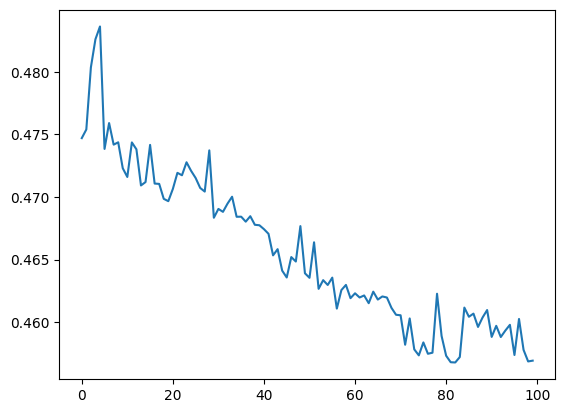

In [7]:
import matplotlib.pyplot as plt
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

````python
#complete code
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
 
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
````

# Improving the Model with Preprocessing

In the above, you see the RMSE is 0.68. Indeed, it is easy to improve the RMSE by polishing the data before training. The problem of this dataset is the diversity of the features: Some are with a narrow range and some are wide. And some are small but positive while some are very negative. This indeed is not very nice to most of the machine learning model.

One way to improve this is to apply a standard scaler. It is to convert each feature into their standard score. In other words, for each feature 
, you replace it with

$z = x - x_{mean} / x_{std}$

This way, every transformed feature is centered around 0 and in a narrow range that around 70% of the samples are between -1 to +1. This can help the machine learning model to converge.

You can apply the standard scaler from scikit-learn. The following is how you should modify the data preparation part of the above code:

In [8]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
 
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

Note that standard scaler is applied after train-test split. The StandardScaler above is fitted on the training set but applied on both the training and test set. You must not apply the standard scaler to all data because nothing from the test set should be hinted to the model. Otherwise you are introducing data leakage.

Other than that, virtually nothing shall be changed: You still have 8 features (only they are not the same in value). You still use the same training loop. If you train the model with the scaled data, you should see the RMSE improved, e.g.,

MSE: 0.29

RMSE: 0.54

However, you need to be careful at the end: When you use the trained model and apply to new data, you should apply the scaler to the input data before feed into the mode. That is, inference should be done as follows:

In [9]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples from the original test set
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[   5.2522       16.            6.4640884     0.98342541  566.
    3.12707182   37.32       -120.43      ] -> [-0.44172385] (expected [1.253])
[   4.1708       33.            4.6641791     1.02985075  866.
    3.23134328   33.89       -118.14      ] -> [-0.53296304] (expected [1.75])
[ 7.47340000e+00  2.60000000e+01  7.46507666e+00  1.05281090e+00
  1.72800000e+03  2.94378194e+00  3.44700000e+01 -1.19810000e+02] -> [-0.34153026] (expected [4.322])
[   4.3636       15.            3.79435484    1.07258065  366.
    1.47580645   33.72       -117.76      ] -> [-0.40898407] (expected [1.484])
[ 5.97140000e+00  3.50000000e+01  6.23015873e+00  1.01587302e+00
  1.24800000e+03  3.30158730e+00  3.73100000e+01 -1.22020000e+02] -> [-0.41686076] (expected [3.325])


The following is the complete code:

MSE: 0.31
RMSE: 0.55


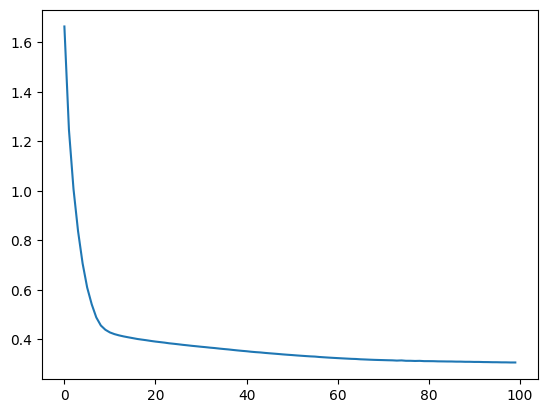

[ 2.75460000e+00  4.00000000e+01  3.42159383e+00  9.61439589e-01
  1.27600000e+03  3.28020566e+00  3.73200000e+01 -1.21880000e+02] -> [1.7120285] (expected [1.725])
[ 5.08690000e+00  2.30000000e+01  6.41954023e+00  1.13218391e+00
  1.53500000e+03  2.94061303e+00  3.40200000e+01 -1.17800000e+02] -> [2.2403154] (expected [2.306])
[ 3.70510000e+00  5.20000000e+01  5.68791946e+00  1.15939597e+00
  1.64500000e+03  2.76006711e+00  3.77600000e+01 -1.22390000e+02] -> [2.8087492] (expected [2.537])
[ 1.92500000e+00  4.30000000e+01  2.34355828e+00  1.03144172e+00
  3.92000000e+03  3.00613497e+00  3.40800000e+01 -1.18290000e+02] -> [2.1023304] (expected [3.])
[   2.6417       35.            4.23255814    0.90697674  115.
    2.6744186    38.55       -121.42      ] -> [1.0421157] (expected [0.989])


In [10]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
 
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)
 
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

Of course, there is still room to imporve the model. One way is to present the target in log scale or, equivalently, use `mean absolute percentage error (MAPE)` as the loss function. This is because the target variable is the value of houses and it is in a wide range. For the same error magnitude, it is more an issue for low-valued houses. It is your exercise to modify the above code to produce a better prediction.

# Summary

In this post, you discovered the use of PyTorch to build a regression model.

You learned how you can work through a regression problem step-by-step with PyTorch, specifically:

How to load and prepare data for use in PyTorch
How to create neural network models and choose a loss function for regression
How to improve model accuracy by applying standard scaler